In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import pickle

sys.path.append("../scripts/")

from utils import Utils
from clean_data import DataCleaner
from plot import Plotter
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
utils = Utils()
plotter = Plotter
cleaner = DataCleaner()
plotter = Plotter()

In [4]:
user_engagement = utils.load_data("../data/user_engagement_metric.csv")
user_experience = utils.load_data("../data/user_experience_metrics.csv")

In [10]:
user_engagement.head()


,msisdn/number,session_traffic(bytes),session_freq,session_duration(ms),cluster,engagement_score
0,NaN,1.605760e+09,3.5,325034.0,0,0.000455
1,3.361489e+10,1.605760e+09,3.5,325034.0,0,0.000455
2,3.376054e+10,1.605760e+09,3.5,325034.0,0,0.000455
3,3.362578e+10,1.605760e+09,3.5,325034.0,0,0.000455
4,3.362632e+10,1.605760e+09,3.5,325034.0,0,0.000455


In [9]:
user_experience.head()

,Unnamed: 0,msisdn,handset_type,avg_rtt_(ms),avg_bearer_tp_(kbps),tcp_retrans._vol_(bytes),experience_score
0,0,3.366496e+10,Samsung Galaxy A5 Sm-A520F,47.000000,67.0,2.156957e+07,0.012566
1,1,3.368185e+10,Samsung Galaxy J5 (Sm-J530),70.000000,42.0,2.156957e+07,0.012568
2,2,3.376063e+10,Samsung Galaxy A8 (2018),127.458589,15.0,2.156957e+07,0.012569
3,3,3.375034e+10,undefined,127.458589,88.0,2.156957e+07,0.012565
4,4,3.369980e+10,Samsung Sm-G390F,127.458589,15.0,2.156957e+07,0.012569


#### Task 4.2 - Calculate satisfaction score from experience score and engagement score

In [11]:
user_engagement.rename(columns={"score": "engagement_score"}, inplace=True)
user_experience.rename(columns={"score": "experience_score"}, inplace=True)
user_engagement.rename(columns={"msisdn/number": "msisdn"}, inplace=True)

In [23]:
user_satisfaction_metrics = pd.merge(user_engagement, user_experience, on="msisdn")
user_satisfaction_metrics['satisfaction_score'] = (user_engagement['engagement_score'] + user_experience['experience_score']) / 2

In [24]:
score_df = user_satisfaction_metrics[['msisdn', 'satisfaction_score','engagement_score', 'experience_score']]

In [25]:
score_df['msisdn'] = score_df['msisdn'].astype(str)
score_df = cleaner.remove_nan_categorical(score_df)

/tmp/ipykernel_97438/3782924676.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_df['msisdn'] = score_df['msisdn'].astype(str)


In [46]:
score_df.dropna(inplace=True)

### Top 10 satisfied customers

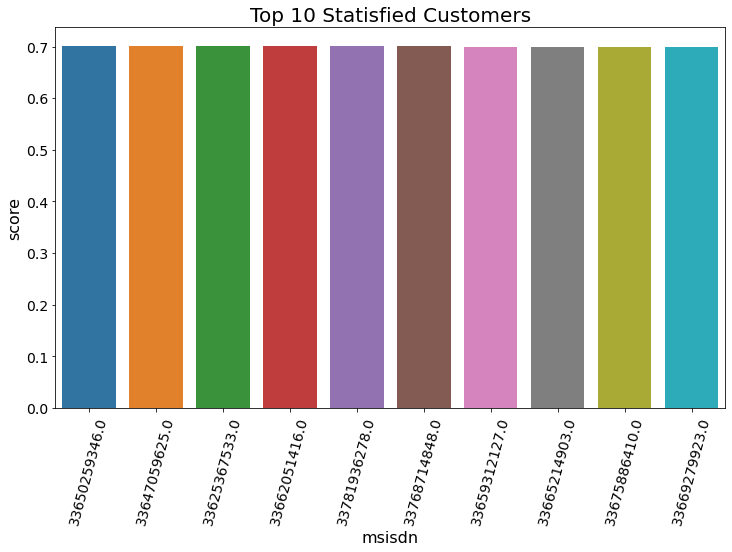

In [47]:
top_10_satisfied = score_df.sort_values(by=['satisfaction_score'], ascending=False).head(10)

scaled_top_score = cleaner.standard_scaler(top_10_satisfied[['satisfaction_score']])
scaled_top_score['msisdn'] = top_10_satisfied['msisdn'].to_list()

Plotter.plot_bar(top_10_satisfied, 'msisdn', 'satisfaction_score', 'Top 10 Statisfied Customers', 'msisdn', 'score')

### Task 4.3 - Build a regression model that predicts satisfaction score

In [48]:
# Get X and Y values for the regression model
X = score_df[['engagement_score', 'experience_score']]
Y = score_df['satisfaction_score']

# Split inpute data into train and test

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10)

reg = LinearRegression()

model = reg.fit(x_train, y_train)
pred = model.predict(x_test)

In [49]:
pred

array([0.03658236, 0.0360008 , 0.03470682, ..., 0.03466412, 0.03386526,
       0.03545459])

### Task 4.4  K-means clustering on engagement score and experience score

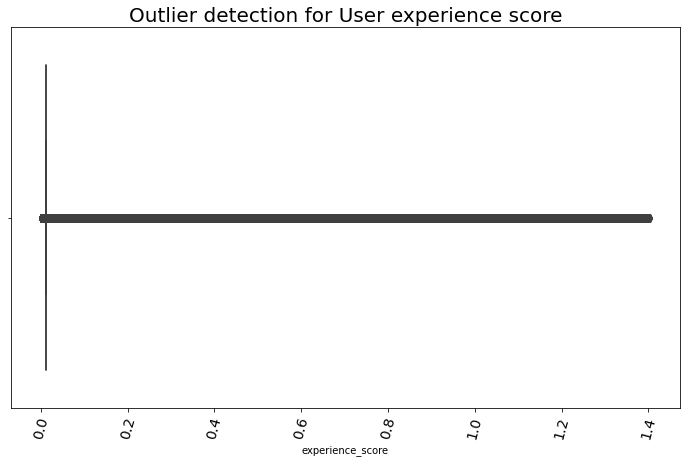

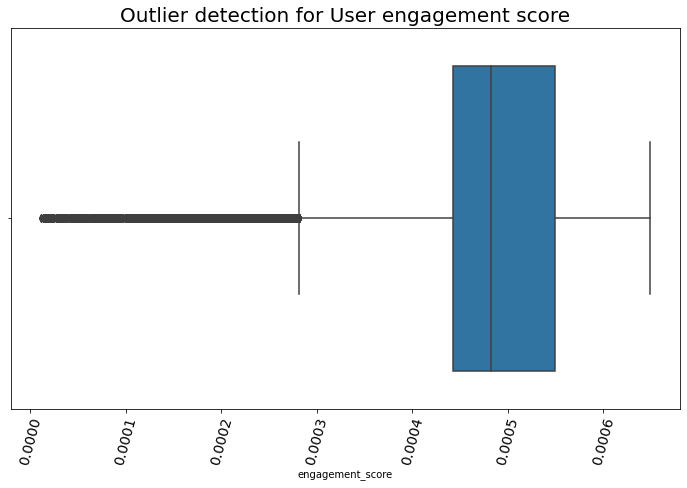

In [51]:
# Check if there are outliers
Plotter.plot_box(score_df,'experience_score', "Outlier detection for User experience score")
Plotter.plot_box(score_df,'engagement_score', "Outlier detection for User engagement score")

In [52]:
# Handle outliers
cleaned_score_df = cleaner.handle_outliers(score_df,'experience_score')
cleaned_score_df = cleaner.handle_outliers(cleaned_score_df,'engagement_score')

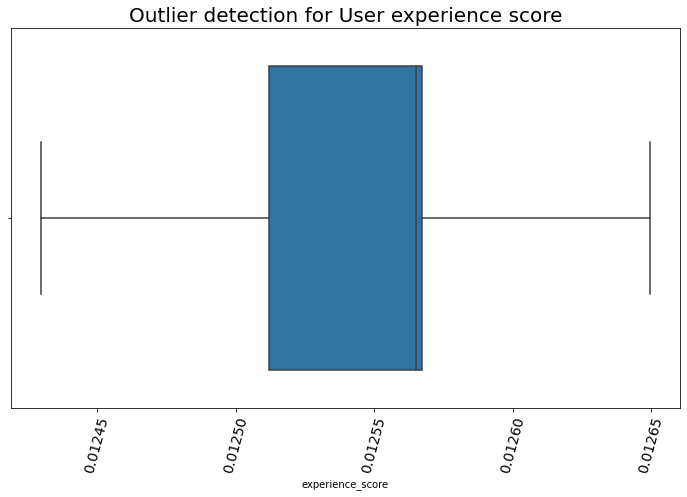

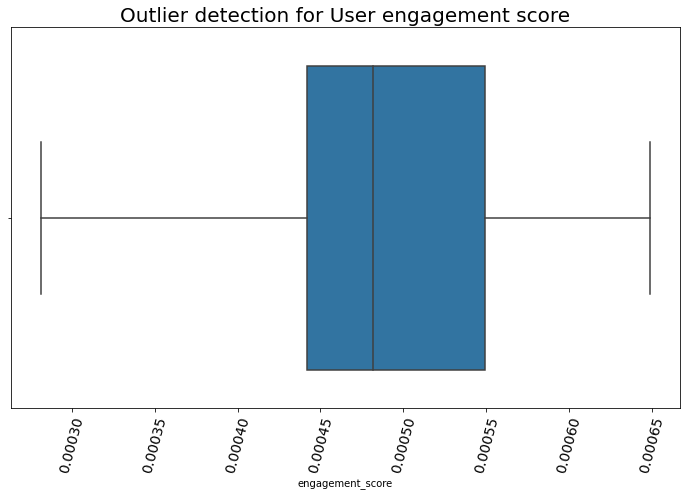

In [54]:
Plotter.plot_box(cleaned_score_df,'experience_score', "Outlier detection for User experience score")
Plotter.plot_box(cleaned_score_df,'engagement_score', "Outlier detection for User engagement score")

Outliers have been corrected

In [55]:
# Normalize the data before clustering
normalized_score_df = cleaner.normalizer(cleaned_score_df)


In [61]:
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=10).fit(normalized_score_df)
pred = kmeans.predict(normalized_score_df)

score_df_with_cluster = score_df.copy()
score_df_with_cluster['cluster'] = pred
score_df_with_cluster['cluster'].value_counts()

norm_score = normalized_score_df.copy()
norm_score['cluster'] = pred


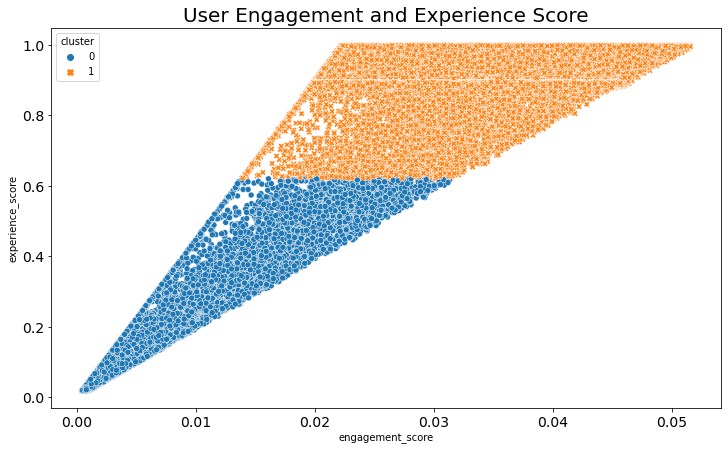

In [62]:
Plotter.plot_scatter(norm_score,'engagement_score', 'experience_score', 'User Engagement and Experience Score','cluster','cluster')

### Task 4.5 - Aggregate the average satisfaction and experience score per cluster

In [63]:
avg_cluster_scores = score_df_with_cluster.groupby(['cluster']).mean()
avg_cluster_scores.head()

,satisfaction_score,engagement_score,experience_score
cluster,,,
0,0.191057,0.000479,0.065698
1,0.006090,0.000480,0.065292
